In [108]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from matplotlib import patches
from functools import reduce
import time
from PIL import Image, ImageDraw, ImageFont
from IPython.display import clear_output
import librosa
!pwd
from skimage.restoration import denoise_tv_bregman
from skimage import filters
from matplotlib import patches


/Users/raminanushiravani/Desktop/mouse_videos


In [82]:
disp = 0

In [83]:
save_path = "/Users/raminanushiravani/Desktop/mouse_videos/"
pathI = "/Users/raminanushiravani/Desktop/mouse_videos/injured/"
filesInj = os.listdir(pathI)
folInj = []
for file in filesInj:
    if '.avi' not in file:
        folInj.append(file)
        
pathH = "/Users/raminanushiravani/Desktop/mouse_videos/healthy/"
folHlt = []
filesHlt = os.listdir(pathH)
for file in filesHlt:
    if '.avi' not in file:
        folHlt.append(file)

In [84]:
healthy_frames = {}
for fol in folHlt:
    try:
        file = os.listdir(pathH + fol)
        healthy_target_filename = pathH + fol + '/' + file[0]
        framesH = [pathH + fol + '/frames/' + f for f in os.listdir(pathH + fol + '/frames')]
        healthy_frames[healthy_target_filename] = sorted(framesH, key = lambda x: (len(x.split('/')[-1]), x))

    except: 
        x = 0
        
injured_frames = {}

for fol in folInj:
    try:
        file = os.listdir(pathI + fol)
        injured_target_filename = pathI + fol + '/' + file[0]
        framesI = [pathI + fol + '/frames/' + f for f in os.listdir(pathI + fol + '/frames')]
        injured_frames[injured_target_filename] = sorted(framesI, key = lambda x: (len(x.split('/')[-1]), x))
    except: 
        x = 0 
        


In [85]:
from scipy import signal
from scipy.signal import argrelextrema

def extract_walking_frames(meanxs, offset):
    
    b, a = signal.butter(5, 0.2)
    y = signal.filtfilt(b, a, np.array(meanxs), padlen=10)
    plt.plot(y)

    local_max_idx = argrelextrema(y, np.greater)
    local_min_idx = argrelextrema(y, np.less)

    walking_frames = []
    for imin,imax in zip(local_min_idx[0],local_max_idx[0]):
        if abs(imax-imin)<10:
            walking_frames.append((min(imax+offset,imin+offset),max(imax+offset,imin+offset)))
    return walking_frames

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/039350_left_continue_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_3_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/038024_left_continue_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/039348_left_ni

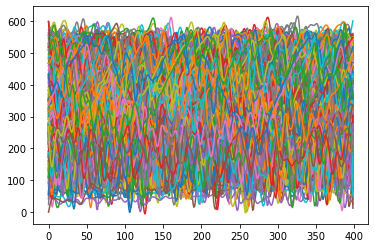

In [86]:
batch = []
images = []
dict_video = {}
walking_frames_videos = {}
offset = 400

for hi_frames in [healthy_frames,injured_frames]:
    
    for k in hi_frames.keys():
        
        walking_frames = []
        fname = k.split('image.')[0][0:-1]
        print(fname)
        names = hi_frames[k]
        sorted_names = sorted(names, key = lambda xx : int(xx.split('/')[-1].split('.')[0]))
        count = 0

        for frame_path in sorted_names:
            
            try:
                image_data = plt.imread(frame_path)
                image_data = np.int32(np.mean(image_data,axis = -1 ))
                batch.append(image_data)
            except:
                x = 1 
                
            print(len(batch),end='\r')
            
            if len(batch) >= offset:  
                o1 = offset * count
                count += 1 
                batch_arr = np.array(batch).squeeze()
                meanxs = [] 
                kk = 1
                count_index = 0
                diff_batch = batch_arr[0:-1,:,:] - batch_arr[1:,:,:] 
                for xx in diff_batch:
                    count_index += 1 
                    mean_x = np.mean(xx[:,0:600]>0,axis=0)
                    b, a = signal.butter(8, 0.025)
                    y = signal.filtfilt(b, a, np.array(mean_x), padlen=150)
                    meanxs.append(np.argmax(y))
                    if disp:
                        figure, ax = plt.subplots(2,2,figsize=(20,10))
                        ax[0][0].imshow(xx>0)
                        ax[0][1].imshow(batch_arr[count_index])
                        
                        
                        ax[1][0].plot(np.arange(kk),np.array(meanxs))
                        ax[1][1].plot(y)

                        kk += 1 
                        plt.show()
                        time.sleep(0.001) 
                        clear_output(wait=True)


                walking_frames.append(extract_walking_frames(meanxs,o1))
                batch = []
                
        walking_frames_videos[fname] = walking_frames 

pickle.dump(walking_frames_videos , open(save_path + 'walking_frames_all_videos.pickle','wb'))        


In [87]:

thr_merging = 30
thr_save = 50
def merge_frame_indicies(walking_frames,thr_merging):
    results = []
    count = 0 
    tuples = np.concatenate((walking_frames))

    for tuple_min_max in tuples:
        x = tuple_min_max[0]
        y = tuple_min_max[1]
        if count == 0:
            so_far = [x,y]
            count += 1
        else:
            if x - so_far[1] < thr_merging: 
                so_far[1] = y
            else:
                if so_far[1] - so_far[0] > thr_save:
                    results.append(so_far)
                count = 0
    return results

In [90]:
new_dict

{'/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP': [[11,
   223],
  [278, 436],
  [560, 794],
  [896, 999],
  [1100, 1295],
  [1428, 1628],
  [1684, 1899],
  [2035, 2107],
  [2217, 2464],
  [2528, 2690],
  [2909, 3015],
  [3087, 3325],
  [3696, 3963],
  [4016, 4246],
  [4368, 4502],
  [4558, 4808],
  [4907, 5091],
  [5164, 5438],
  [5524, 5679],
  [5740, 5959],
  [6013, 6067],
  [6243, 6318],
  [6436, 6498],
  [6588, 6721],
  [6785, 6836],
  [6915, 6975],
  [7269, 7404],
  [7579, 7636],
  [7889, 7990],
  [8043, 8108],
  [8147, 8305],
  [8370, 8515],
  [8701, 8917],
  [9152, 9318],
  [9415, 9482],
  [9602, 9734],
  [9825, 9932],
  [10076, 10235],
  [10285, 10366],
  [10425, 10505],
  [10605, 10687],
  [10742, 10810],
  [11167, 11333],
  [11554, 11635],
  [12385, 12438],
  [12521, 12864]],
 '/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP': [[203,
   328],
  [482, 535],
  [600, 780],
  [860, 1124],
  [1308, 13

In [88]:
# collect all frames, concatenate, merge...
new_dict = {}
for k in walking_frames_videos.keys():
    fints = []
    frame_intervals = walking_frames_videos[k]
    fints = merge_frame_indicies(frame_intervals,thr_merging)
    new_dict[k] = fints

In [95]:
import pandas as pd
df = pd.DataFrame.from_dict(new_dict,orient='index')

{'/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP': [[11,
   223],
  [278, 436],
  [560, 794],
  [896, 999],
  [1100, 1295],
  [1428, 1628],
  [1684, 1899],
  [2035, 2107],
  [2217, 2464],
  [2528, 2690],
  [2909, 3015],
  [3087, 3325],
  [3696, 3963],
  [4016, 4246],
  [4368, 4502],
  [4558, 4808],
  [4907, 5091],
  [5164, 5438],
  [5524, 5679],
  [5740, 5959],
  [6013, 6067],
  [6243, 6318],
  [6436, 6498],
  [6588, 6721],
  [6785, 6836],
  [6915, 6975],
  [7269, 7404],
  [7579, 7636],
  [7889, 7990],
  [8043, 8108],
  [8147, 8305],
  [8370, 8515],
  [8701, 8917],
  [9152, 9318],
  [9415, 9482],
  [9602, 9734],
  [9825, 9932],
  [10076, 10235],
  [10285, 10366],
  [10425, 10505],
  [10605, 10687],
  [10742, 10810],
  [11167, 11333],
  [11554, 11635],
  [12385, 12438],
  [12521, 12864]],
 '/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP': [[203,
   328],
  [482, 535],
  [600, 780],
  [860, 1124],
  [1308, 13

In [104]:
# spit out a text file containing all frames in a text file for training a paw detection. 
text_file = open("mouse_walking.txt",'w')

for k in new_dict.keys():
    frames = new_dict[k]
    for frame in frames:
        for i in range(frame[0],frame[1]):
            image_file = k +'/frames/' + str(i) + '.jpg'
            text_file.write(image_file)
            text_file.write('\n')
text_file.close()

In [105]:
def sliding_window(image, stepSizeX,stepSizeY, windowSizeX,windowSizeY):
    for y in range(0, image.shape[0], stepSizeX):
        for x in range(0, image.shape[1], stepSizeY):
            yield (x,y , image[y:y + windowSizeY, x:x + windowSizeX])


def find_points(objs):
    thr = 6
    xys = [(2000,2000)]
    zz = []

    for obj in objs: 
        x = obj[0]
        y = obj[1]
        if x - xys[-1][0]<thr or  y-xys[-1][1]<thr:
            xys.append((x,y))
        else:
            xys.append((2000,2000))
            xys.append((x,y))
            
    points = []
    for xy in xys[2:]:
        if xy[0] != 2000: 
            zz.append(xy)
        elif len(zz): 
            x1 = zz[0][0]
            y1 = zz[0][-1]
            x2 = zz[-1][0]
            y2 = zz[-1][-1]
            start = (x1,y1)
            end   = (x2,y2)
            points.append((start,end))
            zz = []
    if len(zz):
        x1 = zz[0][0]
        y1 = zz[0][-1]
        x2 = zz[-1][0]
        y2 = zz[-1][-1]
        start = (x1,y1)
        end   = (x2,y2)
        points.append((start,end))
    return points
      
def plot_frame(frame):
    picture = frame[0]
    x,y = frame[1]
    winx,winy = frame[2]
    plt.imshow(picture[x:x+winx,y:y+winy,:])
    plt.show()
    
stepSizeX = 10
stepSizeY = 5
windowSizeX = 20
windowSizeY = 20

area = windowSizeX * windowSizeY

disp = 0
PROC = 0
PROCC = 0

In [ ]:
filenames = open("mouse_walking.txt",'r').readlines()
frames = {}
for filename in filenames:
    
    fname = filename.split('/frames')
    if 1:
        frame = Image.open(filename.split()[0])
        arr = np.asarray(frame)  # numpy array
        X = np.array([np.mean(arr.T,axis= 0)<180]).T
        black = np.int32(np.mean(arr.T,axis= 0))
        target = np.array([(filters.sobel_h(black) )]).T > -2
        Y = np.array([arr[:,:,0].T>arr[:,:,1].T+40]).T
        Z = np.array([arr[:,:,0].T>arr[:,:,2].T+20]).T
        arr_black = X*arr
        arr_black = Y*arr_black
        arr_black = Z*arr_black
        slide_ = sliding_window(arr_black,stepSizeX,stepSizeY,windowSizeX,windowSizeY)
        objs = []
        while True: 
            try:
                x,y , object_ = next(slide_)
                thr = np.sum(object_>0)
                if thr/area > 0.67 : 
                    objs.append((x,y))
            except:
                break

        rects = []
        rectangles = [] # save 
        if len(objs): 
            points = find_points(objs)

            for point in points:
                xx = point[0][0]
                yy = point[0][1]
                winX = max((point[-1][0]-point[0][0]) + windowSizeX,windowSizeX)
                winY = windowSizeY 

                rectangles.append(((xx,yy),(winX,winY)))
                if disp:
                    rect = patches.Rectangle((xx,yy),winX,winY, edgecolor='r', facecolor="none")
                    rects.append(rect)

        frames[filename.split()[0]] = rectangles
        if disp:
            figure, ax = plt.subplots(1,figsize=(40,40))
            ax.imshow(arr)
            for rect in rects:
                ax.add_patch(rect)
            plt.show()
            time.sleep(0.1)
            clear_output(wait=True)
    else: 
        print("XX " + filename)
        
    print(filename , end='\r')
    

pickle.dump(frames, open('/Users/raminanushiravani/Desktop/mouse_videos/walking_frames_w_paw_location.pickle','wb'))



/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/13.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/14.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/15.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/16.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/17.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/18.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/19.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102heal

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/94.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/95.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/96.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/97.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/98.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/99.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/100.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/101.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/102.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102h

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/173.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/174.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/175.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/176.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/177.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/178.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/179.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/180.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/181.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/0

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/307.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/308.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/309.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/310.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/311.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/312.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/313.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/314.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/315.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/0

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/387.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/388.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/389.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/390.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/391.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/392.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/393.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/394.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/395.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/0

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/591.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/592.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/593.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/594.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/595.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/596.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/597.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/598.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/599.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/0

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/673.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/674.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/675.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/676.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/677.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/678.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/679.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/680.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/681.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/0

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/754.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/755.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/756.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/757.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/758.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/759.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/760.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/761.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/762.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/0

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/943.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/944.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/945.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/0

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1117.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1118.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1119.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1120.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1121.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1122.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1123.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1124.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1125.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1195.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1196.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1197.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1198.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1203.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1278.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1490.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1491.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1492.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1493.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1494.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1495.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1496.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1497.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1498.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1571.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1572.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1573.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1574.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1575.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1576.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1577.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1578.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1579.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1707.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1708.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1709.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1710.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1711.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1712.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1713.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1714.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1715.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1785.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1786.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1787.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1788.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1789.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1790.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1791.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1792.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1793.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1863.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1864.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1865.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1866.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1867.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1868.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1869.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1870.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/1871.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2081.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2082.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2083.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2084.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2085.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2086.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2087.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2088.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2089.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2270.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2271.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2273.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2278.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2349.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2350.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2351.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2353.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2354.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2355.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2356.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2357.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2438.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2574.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2575.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2576.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2577.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2578.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2579.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2580.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2581.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2582.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2653.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2654.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2655.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2656.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2657.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2658.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2659.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2660.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2661.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2951.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2952.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2953.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2954.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2955.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2956.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2957.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2958.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/2959.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3102.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3103.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3104.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3105.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3106.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3107.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3108.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3109.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3110.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3182.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3183.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3184.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3185.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3186.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3187.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3188.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3189.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3190.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3262.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3263.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3264.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3265.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3266.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3267.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3268.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3269.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3270.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3713.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3714.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3715.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3716.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3717.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3718.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3721.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3793.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3794.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3795.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3796.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3797.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3798.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3799.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3800.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3801.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3872.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3873.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3874.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3875.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3876.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3877.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3878.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3879.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3880.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3953.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3954.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3955.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3956.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3957.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3958.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3959.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3960.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/3961.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4088.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4089.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4090.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4091.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4092.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4093.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4094.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4095.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4096.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4169.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4170.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4171.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4172.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4173.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4174.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4369.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4370.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4371.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4372.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4373.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4374.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4375.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4376.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4377.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4449.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4450.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4451.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4452.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4453.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4454.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4455.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4456.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4457.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4583.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4584.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4585.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4586.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4587.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4588.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4589.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4590.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4591.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4662.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4663.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4664.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4665.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4666.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4667.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4668.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4669.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4670.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4740.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4741.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4742.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4743.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4746.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4747.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4748.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4919.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4920.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4921.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4922.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4923.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4924.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4925.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4926.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4927.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/4999.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5000.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5001.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5002.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5003.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5004.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5005.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5006.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5007.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5079.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5080.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5081.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5082.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5083.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5084.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5085.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5086.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5087.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5232.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5234.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5235.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5236.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5237.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5238.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5240.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5310.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5311.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5312.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5313.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5314.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5315.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5316.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5317.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5318.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5388.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5389.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5390.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5391.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5392.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5393.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5394.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5395.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5396.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5554.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5555.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5556.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5557.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5558.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5632.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5633.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5634.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5635.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5636.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5637.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5638.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5639.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5640.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5779.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5780.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5781.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5853.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5859.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5860.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5861.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5931.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5932.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5933.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5934.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5935.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5936.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/5939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6064.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6065.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6066.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6243.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6244.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6245.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6246.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6248.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6438.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6439.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6440.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6441.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6442.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6443.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6444.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6608.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6609.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6610.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6611.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6612.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6613.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6688.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6689.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6690.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6691.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6692.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6693.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6694.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6695.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6696.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6832.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6833.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6834.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6835.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6915.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6916.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6917.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6918.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/6919.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7285.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7286.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7287.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7288.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7289.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7290.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7291.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7361.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7362.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7363.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7364.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7365.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7366.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7367.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7368.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7369.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7622.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7623.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7946.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7947.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7948.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7949.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7950.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7951.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7952.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7953.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/7954.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8077.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8078.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8079.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8080.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8081.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8082.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8083.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8084.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8085.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8194.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8195.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8196.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8197.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8198.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8278.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8420.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8421.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8422.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8423.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8424.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8425.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8426.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8499.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8500.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8501.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8502.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8503.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8504.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8505.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8506.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8507.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8767.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8768.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8845.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8846.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8847.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8848.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8849.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8850.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8851.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8852.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/8853.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9161.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9162.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9163.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9164.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9165.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9169.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9240.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9241.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9242.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9243.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9244.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9245.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9246.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9416.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9417.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9418.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9419.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9420.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9421.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9422.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9423.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9424.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9622.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9623.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9624.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9625.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9626.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9698.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9699.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9700.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9705.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9706.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9869.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9870.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9871.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9872.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9873.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9874.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9875.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9876.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/9877.jpg
/Users/raminanushiravani/Desktop/mouse_videos/

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10094.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10095.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10096.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10097.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10098.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10099.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10100.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10101.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10102.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10172.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10173.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10174.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10175.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10176.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10177.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10178.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10179.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10180.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10300.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10301.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10302.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10303.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10304.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10305.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10306.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10307.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10308.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10439.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10440.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10441.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10442.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10443.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10444.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10445.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10446.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10447.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10622.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10623.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10624.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10625.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10626.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10627.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10628.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10752.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10753.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10754.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10755.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10756.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10757.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10758.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10759.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/10760.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11190.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11191.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11192.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11193.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11194.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11195.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11196.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11197.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11198.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11267.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11268.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11269.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11270.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11271.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11273.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11275.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11568.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11569.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11570.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11571.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11572.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11573.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11574.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11575.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/11576.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12396.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12397.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12398.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12399.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12400.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12401.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12402.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12403.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12404.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12564.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12565.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12566.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12567.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12636.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12637.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12638.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12639.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12640.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12641.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12642.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12643.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12644.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12713.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12714.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12715.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12716.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12717.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12718.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12719.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12720.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12721.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12792.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12793.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12794.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12795.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12796.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12797.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12798.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12799.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/036102healthy_continue_20cms_0degUP/frames/12800.jpg
/Users/raminanushiravani/Desktop/mous

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/210.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/211.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/212.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/213.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/214.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/215.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/216.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/217.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/218.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/219.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/294.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/295.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/296.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/297.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/298.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/299.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/300.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/301.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/302.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/303.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/532.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/533.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/534.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/600.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/601.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/602.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/603.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/604.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/605.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/606.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/680.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/681.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/682.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/683.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/684.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/685.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/686.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/687.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/688.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/689.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/763.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/764.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/765.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/766.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/767.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/768.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/772.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/927.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/928.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/929.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/930.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/931.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/932.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/933.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/934.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/935.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/936.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1010.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1011.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1012.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1013.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1014.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1015.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1016.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1017.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1018.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1019.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1095.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1096.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1097.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1098.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1099.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1100.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1101.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1102.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1103.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1104.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1362.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1363.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1364.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1365.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1366.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1367.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1368.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1369.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1370.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1371.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1516.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1517.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1518.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1519.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1520.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1521.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1522.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1523.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1524.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1525.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1601.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1602.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1603.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1604.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1605.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1606.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1607.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1608.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1609.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1610.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1687.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1688.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1689.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1690.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1691.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1692.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1693.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1694.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1695.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1696.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1779.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1780.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1781.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1859.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1860.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1861.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1862.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1863.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1864.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1943.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1944.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1945.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1946.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/1947.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2020.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2021.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2022.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2023.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2024.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2025.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2026.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2027.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2028.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2029.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2105.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2106.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2107.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2108.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2109.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2110.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2111.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2112.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2113.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2114.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2189.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2190.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2191.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2192.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2193.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2194.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2195.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2196.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2197.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2198.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2331.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2332.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2333.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2334.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2335.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2336.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2337.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2338.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2339.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2340.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2480.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2481.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2482.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2483.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2484.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2485.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2486.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2487.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2488.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2489.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2565.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2566.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2567.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2568.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2569.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2570.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2571.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2572.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2573.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2574.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2687.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2688.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2689.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2690.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2691.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2692.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2693.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2694.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2695.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2696.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2779.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2859.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2860.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2861.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2862.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2863.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2943.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2944.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2945.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/2946.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3162.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3163.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3164.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3165.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3169.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3170.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3171.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3244.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3245.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3246.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3248.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3252.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3253.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3378.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3379.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3380.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3381.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3382.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3383.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3384.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3385.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3386.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3387.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3462.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3463.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3464.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3465.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3466.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3467.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3468.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3469.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3470.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3471.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3545.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3546.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3547.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3548.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3549.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3550.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3551.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3552.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3553.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3554.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3900.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3901.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3902.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3903.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3904.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3905.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3906.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3907.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3908.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/3909.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4257.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4258.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4259.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4260.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4261.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4262.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4263.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4264.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4265.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4266.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4339.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4340.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4404.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4405.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4406.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4407.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4408.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4409.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4410.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4411.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4485.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4486.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4487.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4488.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4489.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4490.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4491.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4492.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4493.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4494.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4568.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4569.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4570.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4571.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4572.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4573.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4574.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4575.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4576.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4577.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4782.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4783.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4784.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4785.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4786.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4787.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4788.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4789.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4790.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4791.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4865.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4866.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4867.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4868.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4869.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4870.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4871.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4872.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4873.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/4874.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5004.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5005.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5006.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5007.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5008.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5009.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5010.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5011.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5012.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5013.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5136.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5137.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5138.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5139.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5140.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5141.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5142.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5143.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5144.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5145.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5302.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5303.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5304.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5305.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5306.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5307.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5308.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5309.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5310.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5311.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5440.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5441.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5442.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5443.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5444.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5445.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5446.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5447.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5448.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5449.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5525.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5526.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5528.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5529.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5530.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5531.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5606.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5607.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5608.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5778.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5851.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5852.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5853.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5859.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5860.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5933.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5934.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5935.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5936.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/5942.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6150.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6151.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6152.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6153.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6154.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6155.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6156.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6157.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6158.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6159.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6234.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6235.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6236.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6237.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6238.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6240.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6241.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6242.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6394.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6395.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6396.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6397.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6398.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6399.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6400.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6401.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6402.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6403.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6567.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6568.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6569.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6570.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6571.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6572.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6573.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6574.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6575.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6576.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6823.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6824.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6825.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6826.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6827.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6828.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6829.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6830.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6831.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6832.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6905.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6906.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6907.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6908.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6909.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6910.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6911.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6912.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6913.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6914.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/6989.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7037.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7038.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7039.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7040.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7041.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7042.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7043.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7044.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7045.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7118.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7119.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7120.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7121.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7122.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7123.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7124.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7125.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7126.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7127.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7476.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7477.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7478.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7479.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7480.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7481.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7482.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7483.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7484.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7485.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7622.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7623.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7624.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7625.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7626.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7627.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7628.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7705.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7706.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7707.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7708.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7709.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7710.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7826.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7827.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7828.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7829.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7830.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7831.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7832.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7833.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7834.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7835.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7997.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7998.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/7999.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8000.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8001.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8002.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8003.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8004.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8005.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8006.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8082.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8083.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8084.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8085.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8086.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8087.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8088.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8089.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8090.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8091.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8231.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8232.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8234.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8235.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8236.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8237.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8238.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8240.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8547.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8548.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8549.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8550.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8551.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8552.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8553.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8554.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8555.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8556.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8679.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8680.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8681.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8682.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8683.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8684.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8685.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8686.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8687.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8688.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8914.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8915.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8916.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8917.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8918.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8919.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8920.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8921.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8922.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8923.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8997.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8998.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/8999.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9000.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9001.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9002.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9003.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9004.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9005.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9006.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9170.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9171.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9172.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9173.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9174.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9175.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9176.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9177.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9178.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9179.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9349.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9350.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9351.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9353.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9354.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9355.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9356.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9357.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_3_20cms_0degUP/frames/9358.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/252.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/253.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/254.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/255.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/256.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/257.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/258.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/259.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/336.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/337.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/338.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/339.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/340.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/341.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/342.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/343.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/344.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/345.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/419.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/420.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/421.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/422.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/423.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/424.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/425.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/426.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/428.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/505.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/506.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/507.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/508.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/509.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/510.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/513.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/514.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/591.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/592.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/593.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/594.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/595.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/596.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/597.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/598.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/599.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/600.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/741.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/742.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/743.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/746.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/747.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/748.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/749.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/750.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/824.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/825.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/826.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/827.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/828.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/829.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/830.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/831.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/832.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/833.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/974.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/975.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/976.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/977.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/978.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/979.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/980.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/981.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/982.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/983.jpg
/Users/ram

/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1059.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1060.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1061.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1062.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1063.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1064.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1065.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1066.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1067.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1068.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1142.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1143.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1144.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1145.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1146.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1147.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1148.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1149.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1150.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1151.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1451.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1452.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1453.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1454.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1455.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1456.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1457.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1458.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1459.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1460.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1573.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1574.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1575.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1576.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1577.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1578.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1659.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1660.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1661.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1662.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1737.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1738.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1739.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1740.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1741.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1742.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1743.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1746.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1821.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1822.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1823.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1824.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1825.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1826.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1827.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1828.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1829.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1830.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1905.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1906.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1907.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1908.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1909.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1910.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1911.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1912.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1913.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1914.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1989.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1990.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1991.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1992.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1993.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1994.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1995.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1996.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1997.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/1998.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2169.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2170.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2171.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2172.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2173.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2174.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2175.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2176.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2252.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2253.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2254.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2255.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2256.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2257.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2258.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2331.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2332.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2333.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2334.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2335.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2336.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2337.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2338.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2339.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2340.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2759.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2760.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2761.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2762.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2763.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2764.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2765.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2766.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2767.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2768.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2892.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2893.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2894.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2895.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2896.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2897.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2898.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2899.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2900.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2901.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2975.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2976.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2977.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2978.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2979.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2980.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2981.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2982.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2983.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/2984.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3221.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3222.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3223.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3224.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3225.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3226.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3227.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3228.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3229.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3230.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3304.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3305.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3306.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3307.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3308.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3309.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3310.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3311.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3312.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3313.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3387.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3388.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3389.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3390.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3391.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3392.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3393.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3394.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3395.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3396.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3519.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3520.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3521.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3522.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3523.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3524.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3525.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3526.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3528.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3601.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3602.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3603.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3604.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3605.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3728.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3729.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3730.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3731.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3732.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3807.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3808.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3809.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3810.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3811.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3812.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/3813.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4046.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4047.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4048.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4121.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4122.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4123.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4124.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4125.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4126.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4127.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4344.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4345.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4346.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4421.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4422.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4423.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4424.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4425.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4426.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4430.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4504.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4505.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4506.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4507.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4508.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4509.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4510.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4513.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4705.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4706.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4707.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4708.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4709.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4710.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4711.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4712.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4713.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4789.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4790.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4791.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4792.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4793.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4794.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4795.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4796.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4797.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4798.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4934.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4935.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4936.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/4943.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5198.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5203.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5204.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5205.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5206.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5207.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5285.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5286.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5287.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5288.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5289.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5362.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5363.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5364.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5365.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5366.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5367.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5368.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5369.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5370.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5371.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5445.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5446.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5447.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5448.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5449.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5450.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5451.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5452.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5453.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5454.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5529.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5530.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5531.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5532.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5533.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5534.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5535.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5536.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5651.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5652.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5910.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5911.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5912.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5913.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5914.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5915.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5916.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5917.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5918.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5919.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5993.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5994.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5995.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5996.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5997.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5998.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/5999.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6000.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6001.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6002.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6243.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6244.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6245.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6246.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6248.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6252.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6327.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6328.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6329.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6330.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6331.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6332.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6333.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6334.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6335.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6674.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6675.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6676.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6677.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6678.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6679.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6680.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6681.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6682.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/6683.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7644.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7645.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7646.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7647.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7648.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7649.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7650.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7651.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7652.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7653.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7844.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7845.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7846.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7847.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7848.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7849.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7850.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7851.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7852.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/7853.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8029.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8030.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8031.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8032.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8033.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8034.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8035.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8036.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8037.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8038.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8113.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8114.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8115.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8116.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8117.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8118.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8119.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8120.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8121.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8122.jpg


/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8197.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8198.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8203.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8204.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8205.jpg
/Users/raminanushiravani/Desktop/mouse_videos/healthy/healthy_NSG336_1_20cms_0degUP/frames/8206.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/31.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/32.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/33.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/34.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/35.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/36.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/37.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/38.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/39.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/fram

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/114.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/115.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/116.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/117.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/118.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/119.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/120.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/121.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/122.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/318.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/319.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/320.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/321.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/323.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/324.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/325.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/564.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/565.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/566.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/567.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/568.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/569.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/570.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/571.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/792.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/793.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/794.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/795.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/796.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/797.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/798.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/799.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/800.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/874.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/875.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/876.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/877.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/878.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/879.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/880.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/881.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/882.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/958.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/959.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/960.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/961.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/962.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/963.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/964.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/965.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/966.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0d

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1097.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1098.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1099.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1100.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1101.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1102.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1103.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1104.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1105.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1177.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1178.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1179.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1180.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1181.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1182.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1375.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1376.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1377.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1451.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1452.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1453.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1454.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1455.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1456.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1457.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1458.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1459.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1533.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1645.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1646.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1647.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1648.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1649.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1650.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1651.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/1652.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2023.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2024.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2025.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2026.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2027.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2028.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2029.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2030.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2031.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2285.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2286.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2287.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2288.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2289.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2290.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2364.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2365.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2366.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2367.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2368.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2369.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2370.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2371.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2372.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2506.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2507.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2508.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2509.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2510.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2513.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2514.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2589.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2590.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2591.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2592.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2593.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2594.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2595.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2596.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2597.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2934.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2935.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2936.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2941.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/2942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3073.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3074.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3075.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3076.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3077.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3078.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3079.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3080.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3081.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3154.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3155.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3156.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3157.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3158.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3159.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3160.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3161.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3162.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3622.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3694.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3695.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3696.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3697.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3698.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3699.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3700.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3836.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3837.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3838.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3839.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3840.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3841.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3842.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3843.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3844.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3916.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3917.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3918.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3919.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3920.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3921.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3922.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3923.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/3924.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4051.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4052.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4053.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4054.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4055.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4056.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4057.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4058.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4059.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4203.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4204.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4205.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4206.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4207.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4208.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4209.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4210.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4211.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4285.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4286.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4352.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4353.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4354.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4355.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4356.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4585.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4586.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4587.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4588.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4589.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4590.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4591.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4592.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4593.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4668.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4669.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4670.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4671.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4672.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4673.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4674.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4675.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/4676.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5325.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5327.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5328.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5329.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5330.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5331.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5332.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5333.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5530.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5531.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5532.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5533.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5534.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5535.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5536.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5537.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5538.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5610.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5611.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5612.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5613.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5779.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5780.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5781.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5782.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5969.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5970.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5971.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5972.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5973.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5974.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5975.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5976.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/5977.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6212.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6213.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6214.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6215.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6216.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6217.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6218.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6219.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6220.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6296.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6297.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6298.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6299.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6300.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6301.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6302.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6303.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6304.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6622.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6623.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6696.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6697.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6698.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6699.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6700.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6917.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6918.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6919.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6920.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6921.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6922.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6923.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6924.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/6925.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7058.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7059.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7060.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7061.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7062.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7063.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7064.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7065.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7066.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7139.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7140.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7141.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7142.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7143.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7144.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7145.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7146.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7147.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7509.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7510.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7513.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7514.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7515.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7516.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7517.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7730.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7731.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7732.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7733.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7734.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7735.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7736.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7737.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7738.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7814.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7815.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7816.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7817.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7818.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7819.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7820.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7821.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/7822.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8196.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8197.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8198.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8203.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8204.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8278.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8429.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8430.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8431.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8432.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8433.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8785.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8786.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8787.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8788.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8899.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8900.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8901.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8902.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2_20cms_0degUP/frames/8903.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/rightright_039348_2

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/21.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/22.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/23.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/24.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/25.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/26.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/27.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/28.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/29.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/30.jpg


/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/103.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/104.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/105.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/106.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/107.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/108.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/180.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/181.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/182.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frame

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/337.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/338.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/339.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/340.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/341.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/342.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/343.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/344.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/345.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frame

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/420.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/421.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/422.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/423.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/424.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/425.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/426.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/427.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/428.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frame

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/504.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/505.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/506.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/507.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/508.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/509.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/510.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/511.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/512.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frame

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/587.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/588.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/589.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/590.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/591.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/592.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/593.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/594.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/595.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frame

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/731.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/732.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/733.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/734.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/735.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/736.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/737.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/738.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/739.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frame

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/893.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/894.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/895.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/896.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/897.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/898.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/899.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/900.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/901.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frame

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1072.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1073.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1074.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1075.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1076.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1077.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1078.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1079.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1248.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1252.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1253.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1254.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1255.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1332.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1333.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1334.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1335.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1336.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1337.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1338.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1339.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1340.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1473.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1474.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1475.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1476.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1477.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1478.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1479.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1480.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1481.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1612.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1613.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1695.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1696.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1697.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1698.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1699.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1700.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1841.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1842.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1843.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1844.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1845.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1846.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1847.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1848.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/1849.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2033.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2034.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2035.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2036.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2037.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2038.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2039.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2040.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2041.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2118.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2119.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2120.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2121.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2122.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2123.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2124.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2125.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2126.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2199.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2200.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2201.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2202.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2203.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2204.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2205.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2206.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2207.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2556.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2557.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2558.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2564.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2695.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2696.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2697.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2698.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2699.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2700.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2779.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2780.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2781.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2782.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2783.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2784.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2785.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2859.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2860.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2861.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2862.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2863.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2864.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2865.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2866.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2867.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2942.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2943.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2944.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2945.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2946.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2947.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2948.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2949.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/2950.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3074.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3075.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3076.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3077.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3078.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3079.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3080.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3081.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3082.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3282.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3283.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3284.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3285.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3286.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3287.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3288.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3289.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3365.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3366.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3367.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3368.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3369.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3370.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3371.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3372.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3373.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3553.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3554.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3555.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3556.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3557.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3558.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3559.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3705.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3706.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3707.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3708.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3709.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3986.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3987.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3988.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3989.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3990.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3991.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3992.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3993.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/3994.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4070.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4072.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4073.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4074.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4075.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4076.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4077.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0degUP/frames/4078.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/right_right_039348_20cms_0de

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/42.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/43.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/44.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/45.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/46.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/47.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/48.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/49.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/50.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/51.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/fr

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/267.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/268.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/269.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/270.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/271.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/273.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/356.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/357.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/358.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/359.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/360.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/361.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/362.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/363.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/364.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/365.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/620.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/621.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/622.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/623.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/764.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/765.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/766.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/767.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/768.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/854.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/855.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/856.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/857.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/858.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/859.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/860.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/861.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/862.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/863.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/986.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/987.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/988.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/989.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/990.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/991.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/992.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/993.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/994.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/995.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1075.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1076.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1077.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1078.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1079.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1080.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1081.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1082.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1083.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1084.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1169.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1170.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1171.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1172.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1173.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1174.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1175.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1315.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1316.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1317.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1318.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1319.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1320.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1321.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1323.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1324.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1406.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1407.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1408.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1409.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1410.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1411.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1412.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1413.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1414.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1415.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1497.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1498.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1499.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1500.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1501.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1502.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1503.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1504.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1505.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1506.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1585.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1586.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1587.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1588.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1589.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1590.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1591.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1592.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1593.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1594.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1674.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1675.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1676.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1677.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1678.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1679.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1680.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1681.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1682.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1683.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1766.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1767.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1768.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/1775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2008.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2009.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2010.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2011.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2012.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2013.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2014.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2015.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2016.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2017.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2096.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2097.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2098.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2099.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2100.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2101.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2102.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2103.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2104.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2105.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2184.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2185.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2186.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2187.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2188.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2189.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2190.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2191.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2192.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2193.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2273.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2278.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2279.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2280.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2281.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2560.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2561.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2562.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2563.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2564.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2565.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2566.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2567.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2568.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2569.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2739.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2740.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2741.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2742.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2743.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2744.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2745.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2746.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2747.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2748.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2877.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2878.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2879.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2880.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2881.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2882.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2883.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2884.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2885.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2886.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2969.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2970.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2971.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2972.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2973.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2974.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2975.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2976.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2977.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/2978.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3608.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3609.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3610.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3611.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3612.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3613.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3700.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3701.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3702.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3703.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3705.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3706.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3707.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3708.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3709.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3791.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3792.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3793.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3794.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3795.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3796.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3797.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3798.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3799.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3800.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3931.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3932.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3933.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3934.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3935.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3936.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3937.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3938.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3939.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left039348_20cms_0degUP/frames/3940.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/left03

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/268.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/269.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/270.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/271.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/272.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/273.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/274.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/275.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/276.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/277.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/545.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/546.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/547.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/548.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/549.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/550.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/551.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/552.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/553.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/554.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/679.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/680.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/681.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/682.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/683.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/684.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/685.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/686.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/687.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/688.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/769.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/770.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/771.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/772.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/inju

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1117.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1118.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1119.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1120.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1121.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1122.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1123.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1124.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1125.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1126.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1245.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1246.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1248.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1249.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1250.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1251.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1252.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1253.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1254.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1475.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1476.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1477.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1478.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1479.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1480.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1481.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1482.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1483.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1484.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1634.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1635.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1636.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1637.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1638.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1639.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1640.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1641.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1642.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1643.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1773.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1774.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1775.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1776.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1777.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1778.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1779.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1780.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1781.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/1782.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2099.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2100.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2101.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2102.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2103.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2104.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2105.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2106.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2107.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2108.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2330.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2331.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2332.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2333.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2334.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2335.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2336.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2337.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2338.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2339.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2704.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2705.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2706.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2707.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2708.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2709.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2710.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2711.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2712.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2713.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2841.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2842.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2843.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2844.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2845.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2846.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2847.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2848.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2849.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2850.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2978.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2979.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2980.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2981.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2982.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2983.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2984.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2985.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2986.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/2987.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3067.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3068.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3069.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3070.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3071.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3072.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3073.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3074.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3075.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3076.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3252.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3253.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3254.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3255.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3256.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3257.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3258.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3259.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3260.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3261.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3381.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3382.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3383.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3384.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3385.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3386.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3387.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3388.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3389.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3390.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3595.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3596.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3597.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3598.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3599.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3600.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3601.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3602.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3603.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3604.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3895.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3896.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3897.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3898.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3899.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3900.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3901.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3902.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3903.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/3904.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4058.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4059.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4060.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4061.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4062.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4063.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4064.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4065.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4066.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4067.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4144.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4145.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4146.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4147.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4148.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4149.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4150.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4151.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4152.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4153.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4231.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4232.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4233.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4234.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4235.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4236.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4237.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4238.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4240.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4321.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4322.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4323.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4324.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4325.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4326.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4327.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4328.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4329.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4330.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4410.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4411.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4412.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4413.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4414.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4415.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4416.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4417.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4418.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4419.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4496.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4497.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4498.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4499.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4500.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4501.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4502.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4503.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4504.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4505.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4582.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4583.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4584.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4585.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4586.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4587.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4588.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4589.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4590.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4591.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4668.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4669.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4670.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4671.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4672.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4673.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4674.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4675.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4676.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4677.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4790.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4791.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4792.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4793.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4794.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4795.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4796.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4797.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4798.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/4799.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5239.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5240.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5241.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5242.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5243.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5244.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5245.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5246.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5247.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5248.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5434.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5435.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5436.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5437.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5438.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5439.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5440.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5441.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5442.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5443.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5523.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5524.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5525.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5526.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5527.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5528.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5529.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5530.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5531.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5532.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5611.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5612.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5613.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5614.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5615.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5616.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5617.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5618.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5619.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/5620.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6165.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6166.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6167.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6168.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6169.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6170.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6171.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6172.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6173.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6174.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6254.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6255.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6256.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6257.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6258.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6259.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6260.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6261.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6262.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6263.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6455.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6456.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6457.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6458.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6459.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6460.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6461.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6462.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6463.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6464.jpg
/Users/raminanushiravani/Desktop/mouse_v

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6541.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6542.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6543.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6544.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6545.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6546.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6547.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6548.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6549.jpg
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/6550.jpg
/Users/raminanushiravani/Desktop/mouse_v